#### **AML Assignment 05 : Transfer Learning**
#### **Task 01 : Image Classification using pre-trained CNN**


- Name: Soumyajoy Kundu
- Roll No: MDS202349

----

* Transfer Learning for image data using CNN
    * Download about 100 images of chickens and 100 images of ducks from the internet
    * In a google colab notebook, fine-tune a pre-trained convolutional neural network to classify duck vs chicken
    * output the classification report

The dataset that is used for the study is available [here!](https://www.kaggle.com/datasets/roudranildas/chicken-images-classification-dataset/data)

### Importing Libraries

In [1]:
import os, sys, random, time, copy
import torch, warnings

import zipfile
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.models import resnet18, ResNet18_Weights
from torchvision import transforms
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from PIL import Image

random.seed(42)
warnings.filterwarnings("ignore")

* Unzipping and loading the data

In [ ]:
with zipfile.ZipFile('/content/5.1_data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

print("Files unzipped to the 'data' folder.")

Files unzipped to the 'data' folder.


In [3]:
def load_images_from_folder(folder, label, max_images=100):
    images = []
    labels = []

    # Get all filenames and shuffle
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    random.shuffle(all_files)

    # Limit to max_images
    selected_files = all_files[:max_images]

    for filename in selected_files:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

* Making sure that the images on chicken folder has a label of 'chicken' and 'duck' otherwise for train, val and test set.
* Also we have randomly extracted 100 images of chicken and duck for our study.

In [4]:
data_path = "/content/data/data"

# Load only 100 chicken and 100 duck images
chicken_path = os.path.join(data_path, 'chicken-images', 'data', 'train')
duck_path = os.path.join(data_path, 'duck-images', 'data', 'train')

chicken_images, chicken_labels = load_images_from_folder(chicken_path, label='chicken', max_images=100)
duck_images, duck_labels = load_images_from_folder(duck_path, label='duck', max_images=100)

# Combined data
all_images = chicken_images + duck_images
all_labels = chicken_labels + duck_labels

# Create DataFrame
data = pd.DataFrame({'image': all_images, 'label': all_labels})

# Shape of the final dataset
print("Total dataset shape:", data.shape)

Total dataset shape: (200, 2)


### Data Visualisation
* Before starting the modelling, we check the composition of our target variable in the study.

In [5]:
# Count occurrences of each label
label_counts = data['label'].value_counts()
label_counts

,count
label,
chicken,100
duck,100


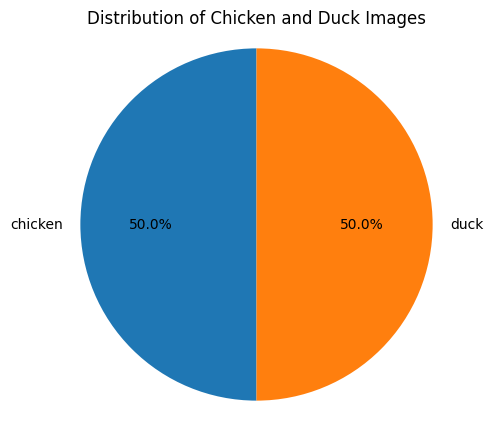

In [6]:
# Create the pie chart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Chicken and Duck Images')
plt.axis('equal')
plt.show()

* The composition of both chicken and duck are fine to work with.
* No need to take measures of data imabalance

### Transfer Learning

#### 1. Making the datasets
* We have to ensure that the train data and test data undergoes certain transforms to go well with the pre-trained model architecture.

In [7]:
# Define a custom image dataset
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]['image']
        label = self.dataframe.iloc[idx]['label']

        # Convert label to numerical representation
        if label == 'chicken':
            label = 0
        elif label == 'duck':
            label = 1
        else:
            raise ValueError(f"Unknown label: {label}")

        # Convert image to PIL Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(data, test_size=0.3, random_state=42, stratify=data['label']) # 70% train, 30% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']) # 15% val, 15% test

In [9]:
train_df.shape, val_df.shape, test_df.shape

((140, 2), (30, 2), (30, 2))

#### 2. Data Transformation
* Making the custom transform for image pre-processing

In [10]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

data_transforms = {
	'train': transforms.Compose([
		transforms.RandomHorizontalFlip(),  # simple data augmentation
		transforms.RandomVerticalFlip(),	# simple data augmentation
		transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)]),

	'val': transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),

  'test': transforms.Compose([
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	])
}

In [11]:
# Create datasets
train_dataset = ImageDataset(train_df, transform = data_transforms['train'])
val_dataset = ImageDataset(val_df, transform = data_transforms['val'])
test_dataset = ImageDataset(test_df, transform = data_transforms['test'])

In [12]:
batch_size = 16

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 140
Validation dataset size: 30
Test dataset size: 30


#### 3. Displaying Train Images

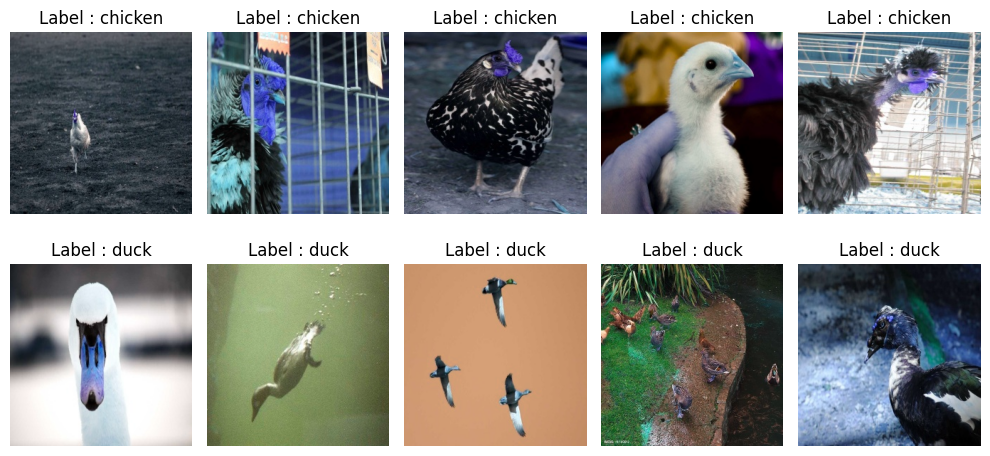

In [ ]:
# Get the first 5 instances of chickens and ducks from the training dataframe
chicken_instances = train_df[train_df['label'] == 'chicken'].head(5)
duck_instances = train_df[train_df['label'] == 'duck'].head(5)

# Display the images and their labels
plt.figure(figsize=(10, 5))

for i, (index, row) in enumerate(chicken_instances.iterrows()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(row['image'])
    plt.title(f"Label : {row['label']}")
    plt.axis('off')

for i, (index, row) in enumerate(duck_instances.iterrows()):
    plt.subplot(2, 5, i + 6)
    plt.imshow(row['image'])
    plt.title(f"Label : {row['label']}")
    plt.axis('off')

plt.tight_layout()
plt.show()

* Defining relevant functions used for training / fine-tuning and evaluating the pre-trained model

In [82]:
def run_validation(model, criterion, val_loader):
    '''
    Evaluates a trained ResNet18 model on a validation dataset.

    Parameters:
    -----------
    model : torch.nn.Module
        The trained PyTorch model to evaluate.
    criterion : torch.nn.modules.loss._Loss
        The loss function used to compute the validation loss (e.g., CrossEntropyLoss).
    val_loader : torch.utils.data.DataLoader
        DataLoader object containing the validation dataset.

    Returns:
    --------
    val_loss : float
        Average loss over the entire validation dataset.
    val_acc : float
        Accuracy score computed on the validation set.
    val_f1 : float
        Macro-averaged F1 score on the validation set.
    orig_labels : np.ndarray
        Ground truth labels collected from the validation set.
    pred_labels : np.ndarray
        Predicted labels by the model for the validation set.
    '''
    model.eval()
    pred_labels = []
    orig_labels = []

    ntotal = 0
    running_loss = 0.0
    with torch.no_grad():
        for ix, batch in enumerate(val_loader):
            inputs, targets = batch

            inputs = inputs.to(torch.float).to(device)
            targets = targets.to(torch.long).to(device)
            output = model(inputs)
            if type(output) == tuple:
                output, _ = output

            _, preds = torch.max(output.data, 1)

            loss = criterion(output, targets)
            ntotal += output.size(0)
            running_loss += loss.item() * output.size(0)

            targets = torch.squeeze(targets).data.cpu().tolist()
            orig_labels = orig_labels + targets

            preds = torch.squeeze(preds).data.cpu().tolist()
            pred_labels = pred_labels + preds

    orig_labels = np.array(orig_labels).reshape(-1,1)
    pred_labels = np.array(pred_labels).reshape(-1,1)

    val_loss = running_loss / ntotal
    val_acc = accuracy_score(orig_labels, pred_labels)
    val_f1 = f1_score(orig_labels, pred_labels, average='macro')

    return val_loss, val_acc, val_f1, orig_labels, pred_labels

In [ ]:
def plot_learning_curve(metrics_per_epoch):
    '''
    Plots training and validation loss and accuracy over epochs.

    Parameters:
    -----------
    metrics_per_epoch : list of tuples
        Each element is a tuple: (train_loss, val_loss, train_acc, val_acc)
        Optionally: can also be (train_loss, val_loss, train_acc, val_acc, train_f1, val_f1)

    Returns:
    --------
    None
        Displays matplotlib plots.
    '''

    epochs = list(range(1, len(metrics_per_epoch)+1))

    # Unpack metrics depending on length
    if len(metrics_per_epoch[0]) == 4:
        train_loss, val_loss, train_acc, val_acc = zip(*metrics_per_epoch)
        train_f1 = val_f1 = None
    elif len(metrics_per_epoch[0]) == 6:
        train_loss, val_loss, train_acc, val_acc, train_f1, val_f1 = zip(*metrics_per_epoch)
    else:
        raise ValueError("Expected each tuple to have 4 or 6 values per epoch.")

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'o-', label='Train Loss', color='royalblue')
    plt.plot(epochs, val_loss, 's--', label='Validation Loss', color='tomato')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'o-', label='Train Accuracy', color='seagreen')
    plt.plot(epochs, val_acc, 's--', label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, base_dir, num_epochs=5):
    '''
    Trains and validates a PyTorch model over a specified number of epochs.

    Parameters:
    -----------
    model : torch.nn.Module
        The neural network model to be trained.
    criterion : torch.nn loss function
        Loss function to be optimized (e.g., nn.CrossEntropyLoss()).
    optimizer : torch.optim.Optimizer
        Optimization algorithm (e.g., optim.Adam).
    dataloaders : dict
        Dictionary containing 'train' and 'val' DataLoader objects.
    dataset_sizes : dict
        Dictionary containing sizes of training and validation datasets.
    base_dir : str
        Directory path to save the best model's weights.
    num_epochs : int, optional (default=5)
        Number of training epochs.

    Returns:
    --------
    model : torch.nn.Module
        The trained model with weights from the best validation epoch.
    metrics_per_epoch : list of tuples
        Each tuple contains:
            (train_loss, val_loss, train_acc, val_acc, train_f1, val_f1)
        for every epoch. This can be used for plotting learning curves.
    '''
    best_acc = 0.0
    since = time.time()
    metrics_per_epoch = []

    for epoch in range(num_epochs):
        print("=" * 70)
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"lr: {optimizer.param_groups[0]['lr']:.6f}")
        print("-" * 70)

        epoch_metrics = {}

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            start_time = time.time()

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')
            elapsed = (time.time() - start_time) / 60

            epoch_metrics[f'{phase}_loss'] = epoch_loss
            epoch_metrics[f'{phase}_acc'] = epoch_acc.item()
            epoch_metrics[f'{phase}_f1'] = epoch_f1

            print(f"Epoch: {epoch+1}/{num_epochs}\t{phase.capitalize()}_Loss: {epoch_loss:.4f}\t"
                  f"Accuracy: {epoch_acc:.4f}\tF1-score: {epoch_f1:.4f}\t{elapsed:.3f}mins")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), os.path.join(base_dir, 'best_model.pth'))

        # Store metrics
        metrics_per_epoch.append((
            epoch_metrics['train_loss'],
            epoch_metrics['val_loss'],
            epoch_metrics['train_acc'],
            epoch_metrics['val_acc'],
            epoch_metrics['train_f1'],
            epoch_metrics['val_f1'],
        ))

        print("=" * 70)

    total_time = (time.time() - since) / 60
    print(f"\nTraining complete in {total_time:.2f} mins")
    print(f"Best Validation Accuracy: {best_acc:.4f}")
    return model, metrics_per_epoch

In [88]:
# Check if GPU is available
use_gpu = torch.cuda.is_available()
print('Using GPU: ', use_gpu)

if use_gpu == True:
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

print(device)

Using GPU:  True
cuda


#### 4. Pre-trained ResNet18 model

In [89]:
# Load pre-trained ResNet18 model with ImageNet weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer to output 2 classes
num_in = model.fc.in_features
model.fc = nn.Linear(num_in, 2)

# Unfreeze last residual block (layer4)
for param in model.layer4.parameters():
    param.requires_grad = True

# Ensure the final fc layer is trainable
for param in model.fc.parameters():
    param.requires_grad = True

# Set model to evaluation mode
model.eval()

# Move the model to the specified device
model.to(device)

# Print model summary
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 5. Training the model -- [ Fine - Tuning ]

In [86]:
base_dir = '/content'

In [85]:
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader
}
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

In [90]:
# Define loss and optimizer (lower lr for more layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    [
        {'params': model.layer3.parameters(), 'lr': 0.0001},
        {'params': model.layer4.parameters(), 'lr': 0.0001},
        {'params': model.fc.parameters(), 'lr': 0.001}
    ],
    momentum=0.9
)

print('Start Training...')
model, epoch_metrics = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, base_dir, num_epochs=35)

Start Training...
Epoch 1/35
lr: 0.000100
----------------------------------------------------------------------
Epoch: 1/35	Train_Loss: 0.8112	Accuracy: 0.4214	F1-score: 0.4214	0.031mins
Epoch: 1/35	Val_Loss: 0.7227	Accuracy: 0.4333	F1-score: 0.3453	0.002mins
Epoch 2/35
lr: 0.000100
----------------------------------------------------------------------
Epoch: 2/35	Train_Loss: 0.6200	Accuracy: 0.6857	F1-score: 0.6816	0.024mins
Epoch: 2/35	Val_Loss: 0.5212	Accuracy: 0.7333	F1-score: 0.7285	0.001mins
Epoch 3/35
lr: 0.000100
----------------------------------------------------------------------
Epoch: 3/35	Train_Loss: 0.4631	Accuracy: 0.8000	F1-score: 0.7996	0.023mins
Epoch: 3/35	Val_Loss: 0.4229	Accuracy: 0.8333	F1-score: 0.8286	0.001mins
Epoch 4/35
lr: 0.000100
----------------------------------------------------------------------
Epoch: 4/35	Train_Loss: 0.3729	Accuracy: 0.8429	F1-score: 0.8421	0.023mins
Epoch: 4/35	Val_Loss: 0.3487	Accuracy: 0.8667	F1-score: 0.8661	0.001mins
Epoch 5/35

#### 6. Learning Curve

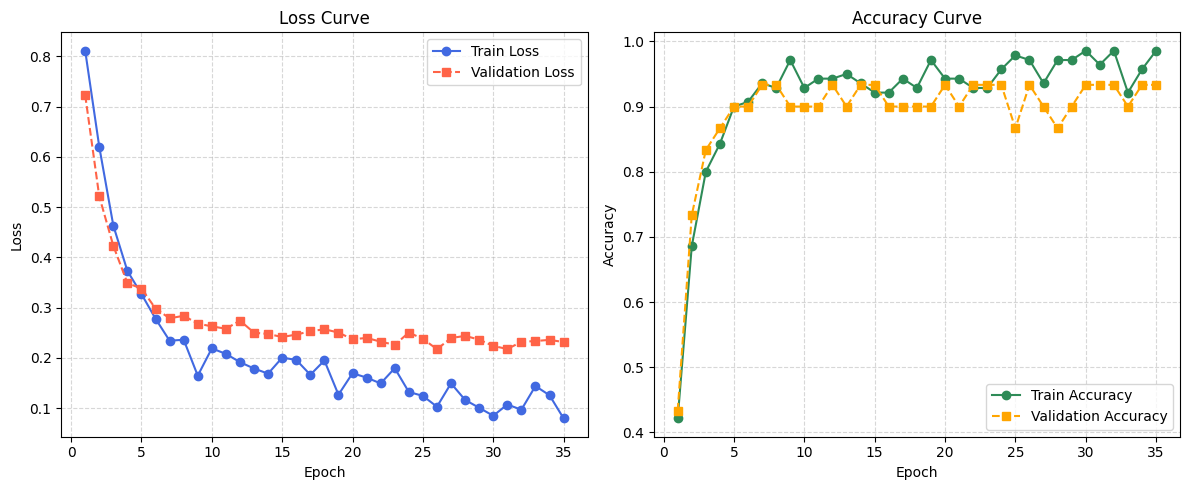

In [96]:
plot_learning_curve(epoch_metrics)

#### 7. Evaluating on Test Set
* Using the best fine-tuned ResNet18 model during training.


In [93]:
# Evaluate the model on the test set
test_loss, test_acc, test_f1, _, _ = run_validation(model, criterion, test_dataloader)

In [94]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1-score: {test_f1:.4f}")

Test Loss: 0.1402
Test Accuracy: 0.9333
Test F1-score: 0.9333


##### 7.1  Classification Report

In [95]:
_, _, _, orig_labels, pred_labels = run_validation(model, criterion, test_dataloader)
print(classification_report(orig_labels, pred_labels, target_names=['duck', 'chicken']))

              precision    recall  f1-score   support

        duck       0.93      0.93      0.93        15
     chicken       0.93      0.93      0.93        15

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



* The fine-tuned ResNet18 model does a very good job in classifying chicken and duck images with both an accuracy and f1-score of around 93%

##### 7.2 Confusion Matrix

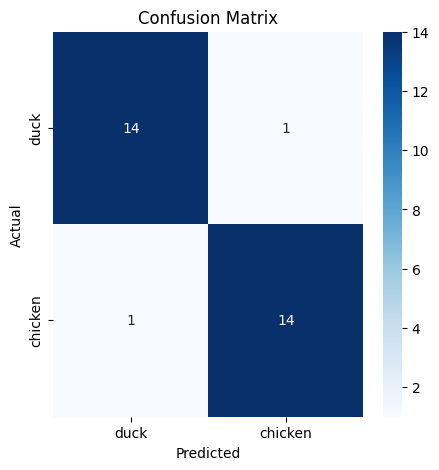

In [97]:
cm = confusion_matrix(orig_labels, pred_labels)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['duck', 'chicken'], yticklabels=['duck', 'chicken'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [106]:
# unnormalize the tensor vector w.r.t the chosen mean and std above
def unnormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Create a subset of 10 random test samples
indices = np.random.choice(len(test_dataset), 10, replace=False)
test_subset = Subset(test_dataset, indices)
test_subset_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

def display_predictions(model, data_loader):
    plt.figure(figsize=(15, 6))  # 5 per row
    model.eval()

    with torch.no_grad():
        for i, (image, label) in enumerate(data_loader):
            if i >= 10:
                break

            image = image.to(device)
            output = model(image)
            _, predicted = torch.max(output.data, 1)

            predicted = predicted.cpu().item()
            label = label.cpu().item()
            label = 'chicken' if label == 0 else 'duck'
            predicted = 'chicken' if predicted == 0 else 'duck'

            color = "green" if predicted == label else "red"

            # Unnormalize
            img = unnormalize(image.squeeze().cpu(), mean, std).numpy()

            # Handle grayscale or RGB
            if img.ndim == 2:
                pass  # Grayscale (H, W)
            elif img.shape[0] == 3:
                img = np.transpose(img, (1, 2, 0))  # RGB (H, W, C)
            else:
                img = img[0]  # Fallback for grayscale (C, H, W) -> (H, W)

            plt.subplot(2, 5, i + 1)
            plt.imshow(img, cmap='gray' if img.ndim == 2 else None)
            plt.title(f"Given: {label}, Pred: {predicted}", color=color, fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

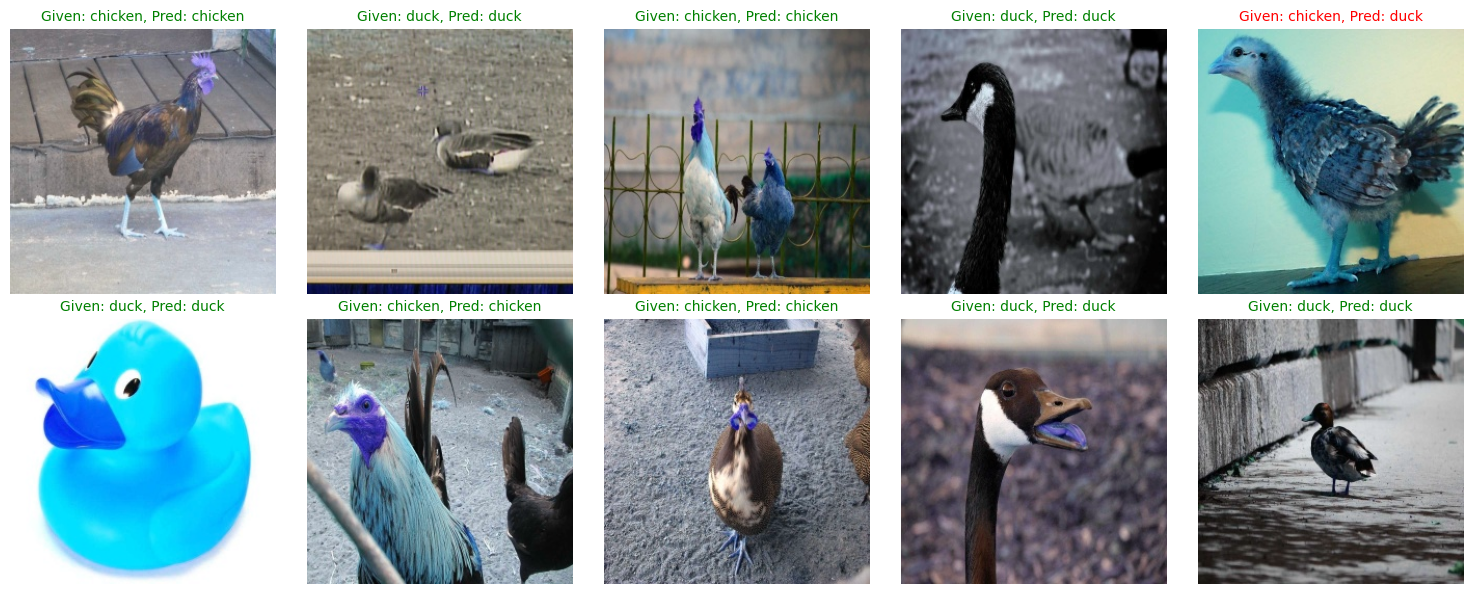

In [107]:
# Display predictions of the best model
display_predictions(model, test_subset_loader)

* Clearly, out of 10 random test inputs, only 1 is predicted incorrectly.
* Thus, our goal of fine-tuning the ResNet18 model for image classification of chicken and duck achieved a good accuracy.